In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [2]:
import arviz as az
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 18

In [3]:
from MMM import mmm

Importing plotly failed. Interactive plots will not work.


# 0. Data Imports

In [4]:
data = pd.read_csv("sales.csv", parse_dates = ["DATE"])
data.columns = [c.lower() if c in ["DATE"] else c for c in data.columns]

In [5]:
data

,date,revenue,tv_S,ooh_S,print_S,facebook_I,search_clicks_P,search_S,competitor_sales_B,facebook_S,events,newsletter
0,2015-11-23,2.754372e+06,167687.6,0,95463.666667,7.290385e+07,0.000000,0,8125009,228213.987444,na,19401.653846
1,2015-11-30,2.584277e+06,214600.9,0,0.000000,1.658110e+07,29511.715457,31000,7901549,34258.573511,na,14791.000000
2,2015-12-07,2.547387e+06,0.0,248022,3404.000000,4.995477e+07,36132.358958,28400,8300197,127691.261335,na,14544.000000
3,2015-12-14,2.875220e+06,625877.3,0,132600.000000,3.164930e+07,36804.210958,31900,8122883,84014.720306,na,2800.000000
4,2015-12-21,2.215953e+06,0.0,520005,0.000000,8.802269e+06,28401.744069,27100,7105985,20687.478156,na,15478.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
203,2019-10-14,2.456240e+06,0.0,60433,153723.666667,0.000000e+00,152840.323412,112100,7612762,0.000000,na,28157.000000
204,2019-10-21,2.182825e+06,154917.6,0,0.000000,5.688196e+07,103680.047821,103700,6701667,133624.575524,na,10644.000000
205,2019-10-28,2.377707e+06,21982.5,14094,17476.000000,0.000000e+00,138387.704138,114700,7688920,0.000000,na,9597.000000
206,2019-11-04,2.732825e+06,22453.0,0,24051.333333,0.000000e+00,151707.990462,134100,8815710,0.000000,na,90189.000000


# 1. Seasonality and Trend Decomposition

To-do
- Convert to method
- Add Holidays optional holidays functionality

In [6]:
START_INDEX = 52
END_INDEX = 144

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/davidmortensen/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/Users/davidmortensen/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/Users/davidmortensen/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/Users/davidmortensen/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append met

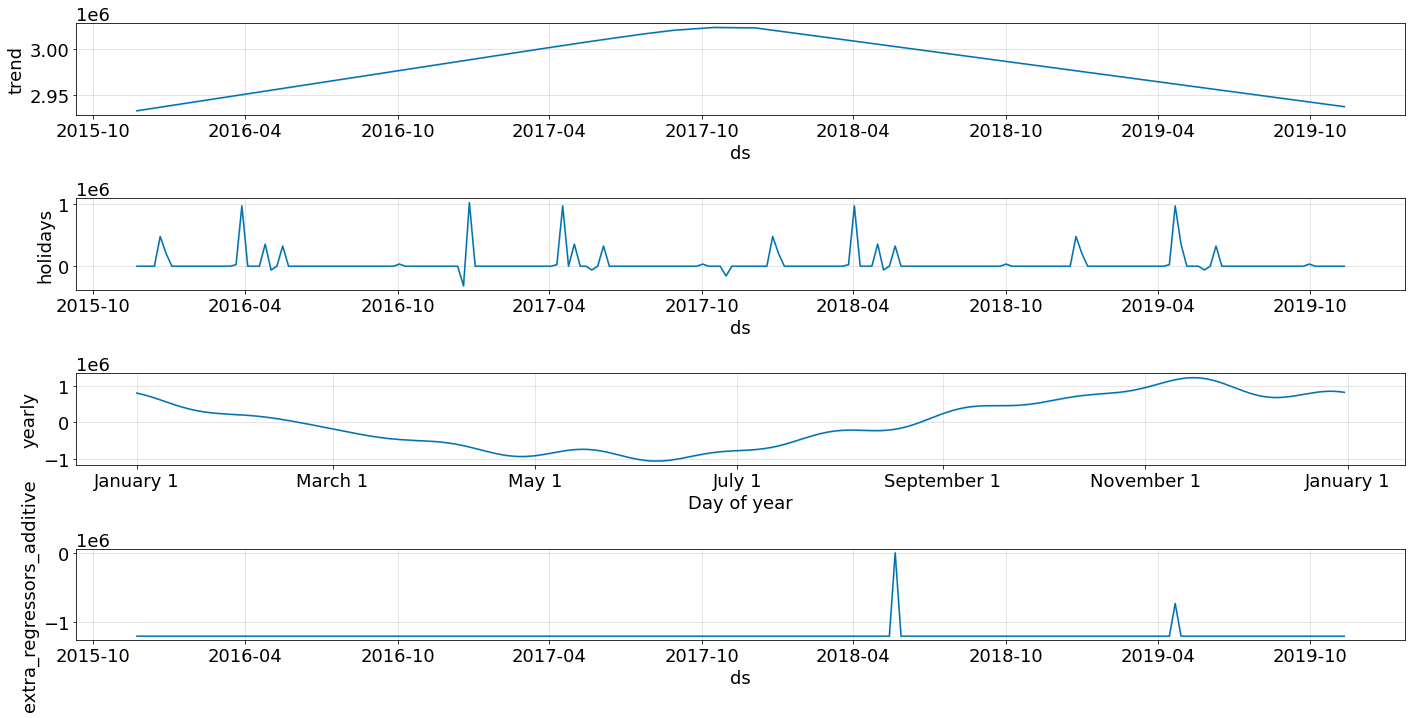

In [7]:
mm_model = mmm()
data = mm_model.decomposition(data, encode_holidays = True, 
                              encode_events = True, 
                              holidays_file = "generated_holidays.csv", 
                              country_code = "DE")
mm_model.plot_decomposition()

# 2. Spend-Exposure estimation

In [8]:
media_spend_exposure_df = mm_model.estimate_spend_exposure(data,
                                                          media_exposures = ["facebook_I", "search_clicks_P"],
                                                          media_spends = ["facebook_S", "search_S"])

# 3. Scaling and Standardization

In [9]:
#choose features/variables to normalize e.g. only independant variables. 
feature_vars = ["trend", 
                "season", 
                "holiday", 
                "competitor_sales_B", 
                "events", 
                "tv_S", 
                "ooh_S", 
                "print_S",
                "facebook_I", 
                "search_clicks_P", 
                "newsletter",
                "revenue"]

target_var = "revenue"

def normalize_data(data, feature_vars):
    data_transformed = data.copy()
    numerical_encoder_dict = {}
    
    for feature in feature_vars:
        scaler = MinMaxScaler()
        original = data[feature].values.reshape(-1, 1)
        transformed = scaler.fit_transform(original)
        data_transformed[feature] = transformed
        numerical_encoder_dict[feature] = scaler
        
    return data_transformed

In [10]:
data_transformed = normalize_data(data, feature_vars)
#data_transformed[target_var] = data[target_var].values / 100_000

# 4. PYMC3 Model

In [11]:
delay_channels = ["tv_S", "ooh_S", "print_S", "facebook_I", "search_clicks_P", "newsletter"]
media_channels = ["tv_S", "ooh_S", "print_S", "facebook_I", "search_clicks_P", "newsletter"]
control_variables = ["trend", "season", "holiday", "competitor_sales_B", "events"]

mm_model.initialize(data_transformed, 
                    delay_channels, 
                    media_channels, 
                    control_variables, 
                    target_var, 
                    START_INDEX = 52, 
                    END_INDEX = 144)

Delay Channels: Adding tv_S


INFO:filelock:Lock 140230555851792 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140230555851792 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140230556364608 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140230556364608 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140230560933776 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140230560933776 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140230561252256 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140230561252256

Delay Channels: Adding ooh_S


INFO:filelock:Lock 140230583505776 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140230583505776 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock


Delay Channels: Adding print_S


INFO:filelock:Lock 140230592374000 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140230592374000 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock


Delay Channels: Adding facebook_I


INFO:filelock:Lock 140230600503152 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140230600503152 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock


Delay Channels: Adding search_clicks_P


INFO:filelock:Lock 140230608313504 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140230608313504 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock


Delay Channels: Adding newsletter


INFO:filelock:Lock 140230597239904 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140230597239904 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140230594616768 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140230594616768 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140230592127376 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140230592127376 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140230591607520 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140230591607520

Control Variables: Adding trend
Control Variables: Adding season
Control Variables: Adding holiday
Control Variables: Adding competitor_sales_B
Control Variables: Adding events


INFO:filelock:Lock 140230585197040 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140230585197040 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140230582712448 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140230582712448 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140230582500464 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140230582500464 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140230581615536 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140230581615536

INFO:filelock:Lock 140230619136928 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140230619136928 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140230619138128 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140230619138128 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140230619209584 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140230619209584 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140230619136880 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140230619136880

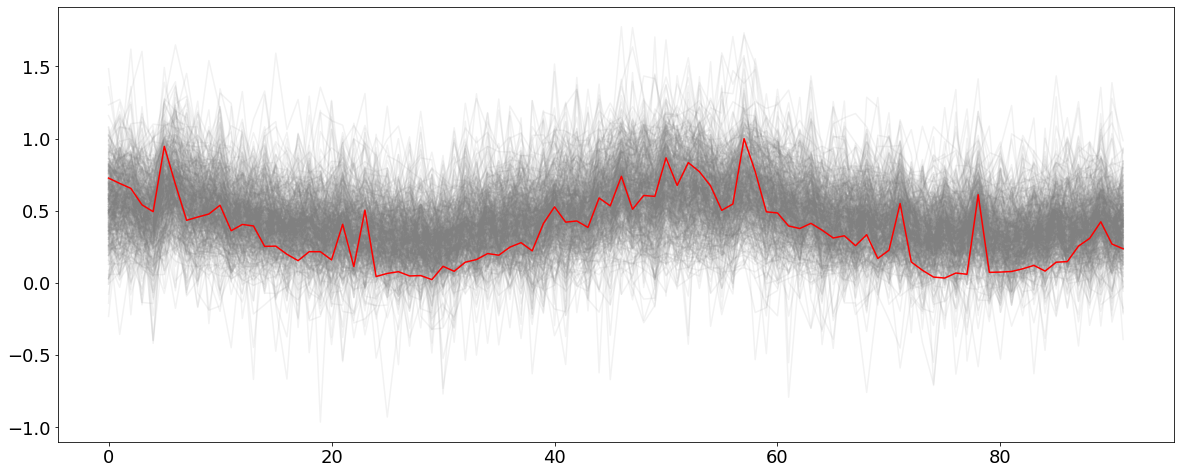

In [12]:
mm_model.plot_prior_predictive(data_transformed)

In [ ]:
trace, trace_summary = mm_model.fit(draws = 1000,
                                    tune = 1000, 
                                    chains = 4, 
                                    cores = 4, 
                                    target_accept = 0.95)

INFO:filelock:Lock 140230631421312 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140230631421312 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140230597212240 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140230597212240 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140230504076528 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140230504076528 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140230504533872 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140230504533872

INFO:filelock:Lock 140230234795264 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140230273914432 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140230273914432 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140230273969216 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140230273969216 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140230274038032 acquired on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140230274038032 released on /Users/davidmortensen/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.8.8-64/.lock
INFO:filelock:Lock 140230274452496

In [ ]:
trace_summary

In [ ]:
mm_model.plot_posterior_predictive()

In [ ]:
mm_model.fit_metrics(data)

# 5. Decomposition

In [ ]:
#Apply media transformations on data with optimized parameters.
data_transformed_decomposed = mm_model.apply_transformations(data_transformed)

In [ ]:
mm_model.plot_model_fit(data_transformed_decomposed)

In [ ]:
#Test accuracies
predictions = mm_model.predict(data_transformed_decomposed, 144, 156, return_metrics = True)

In [ ]:
spend_response_share_df = mm_model.compute_spend_effect_share(data, data_transformed_decomposed, media_spend_exposure_df)

In [ ]:
spend_response_share_df

In [ ]:
mm_model.plot_spend_vs_effect_share(spend_response_share_df)